# Предсказание волатильности

В прошлом ноутбуке было выяснено, что работать с трендом цены актива довольно сложно и безрезультатно. В этом ноутбуке попробуем поработать с волатильностью.

Также в прошлом ноутбуке убедились, что `catboost` и эмбеддинги новостей показали себя в данной задаче лучше других моделей. Поэтому будем использовать эту комбинацию для предсказания волатильности.



---

## Подготовка




Для обработки данных надо реализовать следующие функции



### Необходимые библиотеки

In [ ]:
!pip install catboost
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.5 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=9a2cb117f15382a7440056507bfaa19b5e56b125a571873de57247809bf34a33
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e

In [ ]:
# Базовые библиотеки
import numpy as np
import pandas as pd
import scipy.stats as sps
from scipy.ndimage.interpolation import shift
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

# Визуализация
import plotly.graph_objects as go
from matplotlib import cm
from matplotlib.colors import rgb2hex

# Прикручивает диск к коллабу
from google.colab import drive
drive.mount("/content/drive")

# Модели, метрики
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Библиотеки для обработки текста и получения эмбеддингов
import gensim
import gensim.downloader
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from string import punctuation
from sentence_transformers import SentenceTransformer

nltk.download("punkt")  # для токенизации текстов и работы с пунктуацией
nltk.download("wordnet")  # для графа зависимостей между словами
nltk.download("averaged_perceptron_tagger")
nltk.download("omw-1.4")
nltk.download("stopwords") 

<ipython-input-10-8ce7d237dfc8>:5: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Функция для рассчета трагета

За таргет будем считать $\sigma_T\sqrt{T}$

Где : $\sigma_T$ &mdash; Оценка дисперсии по периоду длины T.

In [ ]:
def volatility_estimation(price, window_size=300):
  """
  Функция для оценки волатильности по периоду равному window_size

  param: price -- массив с ценой актива
  param: window_size -- Размер окна 
  """

  vol = []
  # Рассчет лог-доходности, не берем первый эл-т, т.к. он NaN
  log_return = np.log(price).diff()[1:]
  # Идем по данным с окном window_size, оцениваем дисперсию
  for i in range(len(log_return)-window_size):
        est = np.array(log_return.iloc[i:i+window_size]).std(ddof=1)
        vol.append(est)
  # Для сравнения размера дозаполним массив nan'ами.
  for _ in range(window_size+1):
    vol.append(np.nan)

  return np.array(vol)*np.sqrt(window_size)

### Блок функций для лемматизации текста


Лемматизация текста будет применена при работе с эмбеддингами из `gensim`, т.к. они не такие мощные, как эмбеддинги из `transormers` и требуют очистики текста.

In [ ]:
def get_wordnet_pos(word):
    """Переводит POS tag в один символ для lemmatize()"""

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV,
    }

    return tag_dict.get(tag, wordnet.NOUN)


def LemmatizeAndClearWordList(wordlist):
    """
    Лемматизация списка из слов.
    Причем стоп-слова и пунктуация пропускается при лемматизации

    :param wordlist -- list, список слов

    :return lemmatized_list -- list, лемматизированный и очищенный список слов
    """
    stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
    punc = list(punctuation)  # пунктуация

    punc.append("...")
    punc.append("''")

    cleared_list = []
    lemmatized_list = []
    lemmatizer = WordNetLemmatizer()

    for word in wordlist:
        if word.lower() not in stop_words and word not in punc:
            lemmatized_list.append(lemmatizer.lemmatize(word, get_wordnet_pos(word)))

    return lemmatized_list


def LemmatizeAndClear(dataset):
    """
    Функция для применения лемматизации к датасету

    :param dataset -- Датасет

    :return (text_lemmatized, label_list) -- Список с токенизированными предложениями,
                                                    к которым применили очистку от стоп-слов и лемматизацию,
                                                    а также список меток, соотвествующих им
    """


    text_lemmatized = []
    for text in tqdm(dataset):
      lemmatized = None
      if text is not np.nan:
        lemmatized = LemmatizeAndClearWordList(word_tokenize(text))
      text_lemmatized.append(lemmatized)

    return text_lemmatized

### Блок функций бля получения эмбеддингов

Здесь будут функции для получения эмбеддингов 2 видов. 

* Эмбеддинги из библиотеки `transformers`

* Лемматизация + эмбеддинги из `gensim`

In [ ]:
def word_to_vec_emb(texts):
  """
 Функция для получения w2v эмбддингов из текста
  """
  # Лемматизация
  preprocessed_texts = LemmatizeAndClear(texts)
  # W2V модель для получения эмбеддингов
  model_w2v = gensim.downloader.load('glove-twitter-25')
  embeddings = [] 
  # Эмбеддинги для новостей путем 
  for sentence in tqdm(preprocessed_texts):
      emb = [None]*25
      if sentence is not None:
        emb = np.array([model_w2v.wv[w] for w in sentence if w in model_w2v.wv]).mean(axis=0)
      embeddings.append(emb)
  return embeddings

def transformers_emb(texts):
  """
 Функция для получения эмбддингов из transformers из текста
  """
  model = SentenceTransformer('all-MiniLM-L6-v2')
  embeddings = []
  for sentense in tqdm(texts):
    emb = [np.nan]*384
    if sentense is not np.nan:
      emb = model.encode(sentense)
    embeddings.append(emb)
  return embeddings

### Блок функций для созданий датасета

Здесь будут функции для предобработки данных.

Весь пайплайн обработки состоит из следующих блоков.

* Убираем дубликаты по дате, конкатенируем новости из них

* Преобразуем новости в эмбеддинги

* Рассчитываем таргет, во избежание утечки таргета в силу того, что он рассчитывается из других аттрибутов уберем те, что используются для рассчета

* Деление на тестовую и тренировочную часть данных так, чтобы в тест не попала информация, которая использовалась для рассчета тренировочного таргета

In [ ]:
def split_and_calc_target(data, window_sz, price_col = 'close'):
  """
    Функция для разделения данных на тренировочную и тестовую часть
  """
  # Делим на трейн и тест так, чтобы тренировочная часть данных не видела информации из теста
  X_train, X_test =  data[:-2*(window_sz)], data[-(window_sz):]
  y_train, y_test = volatility_estimation(X_train[price_col], window_sz), volatility_estimation(X_test[price_col], window_sz)
  # Убираем колонку, про которой велся расчет таргета
  X_train, X_test = X_train[X_train.columns.difference([price_col])], X_test[X_test.columns.difference([price_col])]
  X_train, X_test = X_train[:-(window_sz+1)], X_test[:-(window_sz+1)]
  y_train, y_test = y_train[:-(window_sz+1)], y_test[:-(window_sz+1)]
  return X_train, y_train, X_test, y_test

def remove_duplicates(dataset):
    """
    Чистит данные от дубликатов
    """
    # Находим дубликаты по времени
    duple_ind = dataset.duplicated(subset="date", keep=False)
    data_duple = dataset[duple_ind]

    # Конкатенируем новости за одно время
    data_concat = data_duple.groupby(["date"])["text"].apply(".".join).reset_index()

    # Убираем дубликаты из датасета
    data_without_duple = dataset.drop_duplicates(subset=["date"], keep=False)

    # Добавляем данные, которые были опубликованы в одно время
    data_clean = data_without_duple.append(data_concat)

    # Сортирем по дате 
    data_clean = data_clean.sort_values(by=["date"])

    # Для красоты
    data_clean.reset_index(inplace=True)

    return data_clean

def preprocessing_pipline(
    dataset, 
    price_col = 'close',
    use_text = False, 
    emb_func = None 
    ):
  """
  Применяет весь пайплайн обработки данных.
  На выходе имеем обработанные данные, где 'text' не NaN
  """
  # Убираем дубликаты
  dataset = remove_duplicates(dataset)

    # Фичи, которые возьмем для обучения
  other_features = dataset[['volume', 'transactions', price_col, 'date']]

  # Если используем текст, 
  if use_text == True:
    texts = dataset["text"]
    # Получаем эмбеддинги
    embeddings = emb_func(texts)
    # Добавляем в датасет
    for i in range(len(embeddings[0])):
      other_features[f'emd_dim_{i+1}'] = [emb[i] for emb in embeddings ]

  # Пропуски заполняем предыдущими значениями, чтобы не подсмотреть в будущее
  other_features = other_features.fillna(method='ffill', axis = 0)
    
  return other_features

### Создание лаг-фичей для работы временными рядами

Блок функций для работы с временными рядами

In [ ]:
def create_date_features(data):
    """Создает фичи из даты"""

    assert "date" in data.columns,  "No date column"

    data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d %X")

    data["dayofweek"] = [date.dayofweek for date in data["date"]]
    data["quarter"] = [date.quarter for date in data["date"]]
    data["month"] = [date.month for date in data["date"]]
    data["year"] = [date.year for date in data["date"]]
    data["dayofyear"] = [date.dayofyear for date in data["date"]]
    data["dayofmonth"] = [date.day for date in data["date"]]
    data["weekofyear"] = [date.weekofyear for date in data["date"]]
    return data[data.columns.difference(['date'])]

def generate_lag_features_train(dataset, target, shift_lst):
    """Функция создания признаков из дат исдвигов ряда для тренировочных дат
    
    param: dataset -- Тренировочный датасет
    param: target -- Колонка целевой переменной
    param: shift_lst -- Список сдвигов
    """
    for lag in shift_lst:
      dataset[f'lag_{lag}'] = target.shift(lag)

    return dataset



def generate_lag_features_test(dataset_test, target_train, shift_lst):
    """Функция создания признаков из дат и сдвигов ряда для тестовых дат
    
    param: dataset -- Тестовый датасет
    param: target -- Колонка целевой переменной
    param: shift_lst -- Список сдвигов
    """
    test_sz = len(dataset_test)
    for lag in shift_lst:
      lag_feature = target_train.shift(lag - test_sz)
      lag_feature = np.array(lag_feature[-test_sz:])    
      dataset_test[f'lag_{lag}'] = lag_feature
  

    return dataset_test

### Функции для визуализации предсказаний и подсчета метрик

При оценке качества моделей довольно важно понимать, что повлияло на ее структуру(это легко сделать с учетом, что мы выбрали катбуст), а также понять, не сильно ли зашумлено предсказание. Также, чтобы не бегать по ноутбуку в поиске метрик удобно их хранить в одном фрейме. 

Весь этот постпроцессинг для предсказания удобно вынести в отдельную функцию

In [ ]:
metr_df = pd.DataFrame({'Model' : [], 'MSE': [], 'MAE': [], 'MAPE': []})
preds_lst = []
model_nm_lst = []

In [ ]:
def predict_and_postprocess(boosting, y_true, X_test, model_nm, show_feature_importance = True):
    """
    Функция для получения предсказаний модели и последующей обработки
    
    Обработка включает в себя : построение графиков предсказания и истинного значения, график feature importance,
    если модель поддрживает данную функцию, а также занесение метрик качества в таблицу для сравнения
    """
  # Получаем предсказания  
  y_pred = boosting.predict(X_test)
  # Подсчет метрик
  MSE = mean_squared_error(y_true=y_true, y_pred=y_pred)
  MAE = mean_absolute_error(y_true=y_true, y_pred=y_pred)
  MAPE = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
  # Занесение метрик в таблицу  
  df = pd.DataFrame({'Model' : [model_nm], 'MSE': [MSE], 'MAE': [MAE], 'MAPE': [MAPE]})
  global metr_df, preds_lst, model_nm_lst
  metr_df = pd.concat([metr_df, df], ignore_index = True)
  # Печать метрик
  preds_lst.append(y_pred)
  model_nm_lst.append(model_nm)
  print(f"Значение метрик на тесте :\n MSE={MSE:.4}\n MAE={MAE:.4}\n MAPE={MAPE:.4}")
  # Визуализация
  plt.style.use('seaborn')
  if show_feature_importance == True:
    fig, (axs1, axs2) = plt.subplots(2,1, figsize=(12, 12), sharex=False, sharey=False)
    fig.suptitle(model_nm, fontsize = 20)
    # Наносим тест и предсказание
    axs1.plot(np.array(y_true), label ='Истинное значение')
    axs1.plot(np.array(y_pred), label ='Предсказание')
    # Подписи
    axs1.set_ylabel("Волатильность", fontsize=14)
    axs1.set_title('Визуализация предсказания', fontsize=18)
    axs1.legend(loc = 'upper right')
    # Достаем feature importance из модели
    feature_importance = boosting.feature_importances_
    n = min(len(feature_importance), 15)
    sorted_idx = np.argsort(feature_importance)[::-1][:(n+1)]
    # отрисовываем feature importance
    axs2.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    axs2.set_yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    axs2.set_title(f'Feature Importance, top {n}', fontsize = 18)
  else:
    plt.figure(figsize = (16, 8))
    plt.plot(np.array(y_true), label ='Истинное значение')
    plt.plot(np.array(y_pred), label ='Предсказание')

    plt.ylabel("Волатильность", fontsize=14)
    plt.title('Визуализация предсказания', fontsize=18)
    plt.legend(loc = 'upper right')

  plt.show()

---

## Работа с моделями

### Создание датасетов

Загрузим данные

In [ ]:
data = pd.read_csv("/content/drive/My Drive/data/tesla_dataset.csv", index_col=0) # Collab
data.head()

,volume,volume_weighted_price,open,close,high,low,date,transactions,text
0,131762.0,844.8047,844.0200,844.8600,845.7100,843.63,2021-02-09 19:05:00,4954,"By Lawrence White, Anna Irrera\n5 MIN READ\nLO..."
1,93954.0,845.1421,844.9000,844.6950,845.9800,844.52,2021-02-09 19:10:00,4027,NaN
2,76640.0,844.4582,844.5201,844.2401,845.0000,844.00,2021-02-09 19:15:00,3586,NaN
3,129048.0,843.6298,844.2700,843.7899,844.5000,843.00,2021-02-09 19:20:00,5297,NaN
4,111273.0,844.1765,843.5800,844.5000,844.9799,843.29,2021-02-09 19:25:00,4678,NaN


In [ ]:
#preprocessed_data_w2v = pd.read_csv('/content/drive/My Drive/data/preprocessed_data_w2v.csv') 
#preprocessed_data_trans_emb = pd.read_csv('/content/drive/My Drive/data/preprocessed_data_trans_emb.csv') 
#preprocessed_data = pd.read_csv('/content/drive/My Drive/data/preprocessed_data.csv') 

Предобработка данных

In [ ]:
preprocessed_data_w2v = preprocessing_pipline(data, use_text = True, emb_func = word_to_vec_emb)
preprocessed_data_trans_emb = preprocessing_pipline(data, use_text = True, emb_func = transformers_emb)
preprocessed_data = preprocessing_pipline(data)

preprocessed_data_w2v.to_csv('/content/drive/My Drive/data/preprocessed_data_w2v.csv') 
preprocessed_data_trans_emb.to_csv('/content/drive/My Drive/data/preprocessed_data_trans_emb.csv') 
preprocessed_data.to_csv('/content/drive/My Drive/data/preprocessed_data.csv') 

<ipython-input-7-3d52537d6a38>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_clean = data_without_duple.append(data_concat)
100%|██████████| 46767/46767 [01:56<00:00, 401.11it/s]


[================================================--] 96.8% 101.4/104.8MB downloaded


  0%|          | 0/46767 [00:00<?, ?it/s]<ipython-input-5-592aba43dc11>:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  emb = np.array([model_w2v.wv[w] for w in sentence if w in model_w2v.wv]).mean(axis=0)
100%|██████████| 46767/46767 [00:03<00:00, 14444.05it/s]
<ipython-input-7-3d52537d6a38>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_features[f'emd_dim_{i+1}'] = [emb[i] for emb in embeddings ]
<ipython-input-7-3d52537d6a38>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

100%|██████████| 46767/46767 [04:33<00:00, 170.87it/s]
<ipython-input-7-3d52537d6a38>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_features[f'emd_dim_{i+1}'] = [emb[i] for emb in embeddings ]
<ipython-input-7-3d52537d6a38>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_features[f'emd_dim_{i+1}'] = [emb[i] for emb in embeddings ]
<ipython-input-7-3d52537d6a38>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Зададим размер окна для оценки волатильности. Также задаим размер теста, он будет равен окну

In [ ]:
WINDOW_SZ = 300
TEST_SZ = WINDOW_SZ

Разделим данные на трейн и тест

In [ ]:
X_train_v2w, y_train_v2w, X_test_v2w, y_test_v2w = split_and_calc_target(preprocessed_data_w2v, WINDOW_SZ)
X_train_tr, y_train_tr, X_test_tr, y_test_tr = split_and_calc_target(preprocessed_data_trans_emb, WINDOW_SZ)
X_train, y_train, X_test, y_test = split_and_calc_target(preprocessed_data, WINDOW_SZ)


X_train_v2w, X_test_v2w = X_train_v2w[X_train_v2w.columns.difference(['date'])], X_test_v2w[X_test_v2w.columns.difference(['date'])]
X_train_tr, X_test_tr = X_train_tr[X_train_tr.columns.difference(['date'])], X_test_tr[X_test_tr.columns.difference(['date'])]
X_train, X_test = X_train[X_train.columns.difference(['date'])], X_test[X_test.columns.difference(['date'])]

Теперь перейдем к сравнению моделей

### Модель без данных о тексте

In [ ]:
boosting_without_text = CatBoostRegressor(
    random_state=42, 
    n_estimators=1200,
    loss_function = 'MAPE',
    verbose = False
)

boosting_without_text.fit(X_train, y_train)

Значение метрик на тесте :
 MSE=9.15e-05
 MAE=0.007888
 MAPE=0.209


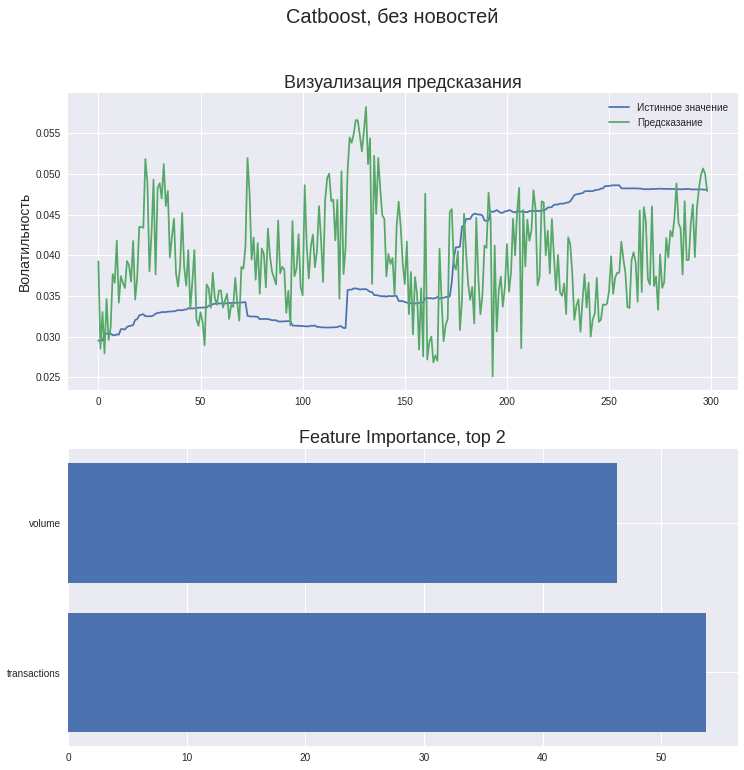

In [ ]:
model_nm = 'Catboost, без новостей'
predict_and_postprocess(boosting_without_text, y_test, X_test, model_nm)

Видно, что модель отработала плохо, при этом предсказания очень зашумлены. Это легко интрепретируется, ведь в для обучения было слишком мало данных

### Модель с данными о тексте, w2v эмбеддинги 

In [ ]:
boosting_v2w = CatBoostRegressor(
    random_state=42, 
    n_estimators=1200,
    loss_function = 'MAPE',
    verbose = False
)

boosting_v2w.fit(X_train_v2w, y_train_v2w)

Значение метрик на тесте :
 MSE=0.0001287
 MAE=0.008696
 MAPE=0.2475


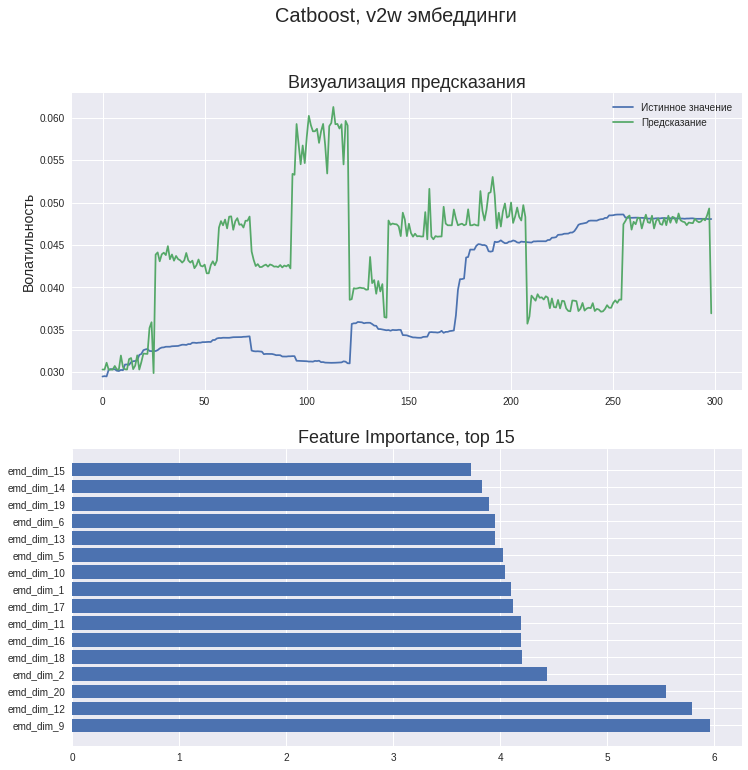

In [ ]:
model_nm = 'Catboost, v2w эмбеддинги'
predict_and_postprocess(boosting_v2w, y_test, X_test_v2w, model_nm)

Видно, что при добавлении эмбеддингов предсказание начала и конца стали куда ближе к истине. Однако, как видно из `feature importance` все эмбеддинги внесли примерно одинаковый небольшой вклад. 

Возможно, модели не удалось хорошо научиться понимать зависимость, однако судя по графикам какие-то основноые моменты (движения вверх и вниз волатильности) она все же научилась в какой-то степени замечать.

### Модель с данными о тексте, эмбеддинги из `tranformers`

In [ ]:
boosting_tr = CatBoostRegressor(
    random_state=42, 
    n_estimators=1200,
    loss_function = 'MAPE',
    verbose = False
)

boosting_tr.fit(X_train_tr, y_train_tr)

Значение метрик на тесте :
 MSE=0.0001333
 MAE=0.008682
 MAPE=0.2541


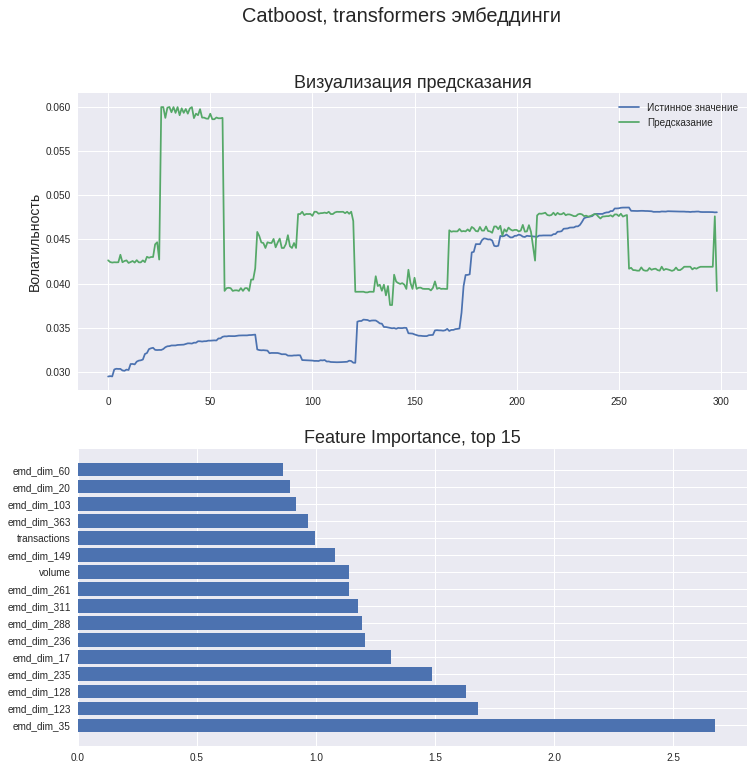

In [ ]:
model_nm = 'Catboost, transformers эмбеддинги'
predict_and_postprocess(boosting_tr, y_test, X_test_tr, model_nm)

Тут ситуация примерно похожа на предыдущую.

У SOTA модели из `transormers` довольно большая размерность эмбеддингов. Вероятно стот попробовать применить какой-нибудь метод для понижения размерности, например PCA.

### Модель с данными о тексте, эмбеддингами из `transformers` + PCA на 120 компонент

In [ ]:
pca = PCA(n_components = 120)

scaler = StandardScaler()
scaler.fit(X_train_tr)

scaled_train = scaler.transform(X_train_tr)
scaled_test = scaler.transform(X_test_tr)

XPCAr_train = pca.fit_transform(scaled_train)
XPCAr_test = pca.fit_transform(scaled_test)

In [ ]:
boosting_pca = CatBoostRegressor(
    random_state=42, 
    n_estimators=1200,
    loss_function = 'MAPE',
    verbose = False
)

boosting_pca.fit(XPCAr_train, y_train_tr)

Значение метрик на тесте :
 MSE=7.542e-05
 MAE=0.007533
 MAPE=0.2107


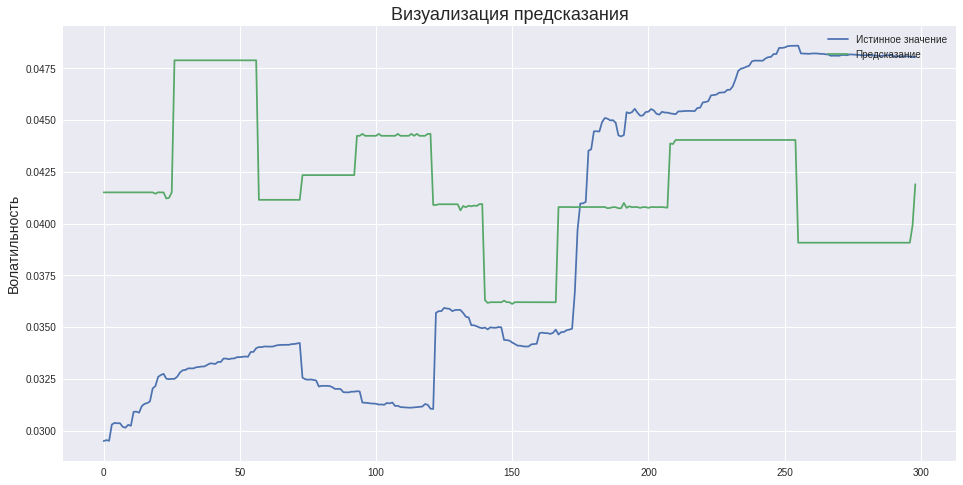

In [ ]:
model_nm = 'Catboost, transformers эмбеддинги + PCA 120 комп.'
predict_and_postprocess(boosting_pca, y_test, XPCAr_test, model_nm, False)

Видно, что PCA преобразование помогло улучшить метрики, однако предсказание лучше от этого не стало.

### Добавление признаков по дате

До это момента модель ничего не знала о дате, что является довольно важным признаком при предсказании временных рядов. Попробуем добавить признаки по дате.

In [ ]:
X_train_tr, y_train_tr, X_test_tr, y_test_tr = split_and_calc_target(preprocessed_data_trans_emb, WINDOW_SZ)
X_train, y_train, X_test, y_test = split_and_calc_target(preprocessed_data, WINDOW_SZ)
X_train_v2w, y_train_v2w, X_test_v2w, y_test_v2w = split_and_calc_target(preprocessed_data_w2v, WINDOW_SZ)

test_dates = X_test['date']

X_train_tr, X_test_tr = create_date_features(X_train_tr) , create_date_features(X_test_tr)
X_train, X_test = create_date_features(X_train), create_date_features(X_test)
X_train_v2w, X_test_v2w = create_date_features(X_train_v2w), create_date_features(X_test_v2w)

#### Без новостных данных, с фичами по дате

In [ ]:
boosting_no_new_and_date = CatBoostRegressor(
    random_state=42, 
    n_estimators=1200,
    loss_function = 'MAPE',
    verbose = False
)

boosting_no_new_and_date.fit(X_train, y_train)

Значение метрик на тесте :
 MSE=3.853e-05
 MAE=0.005712
 MAPE=0.1594


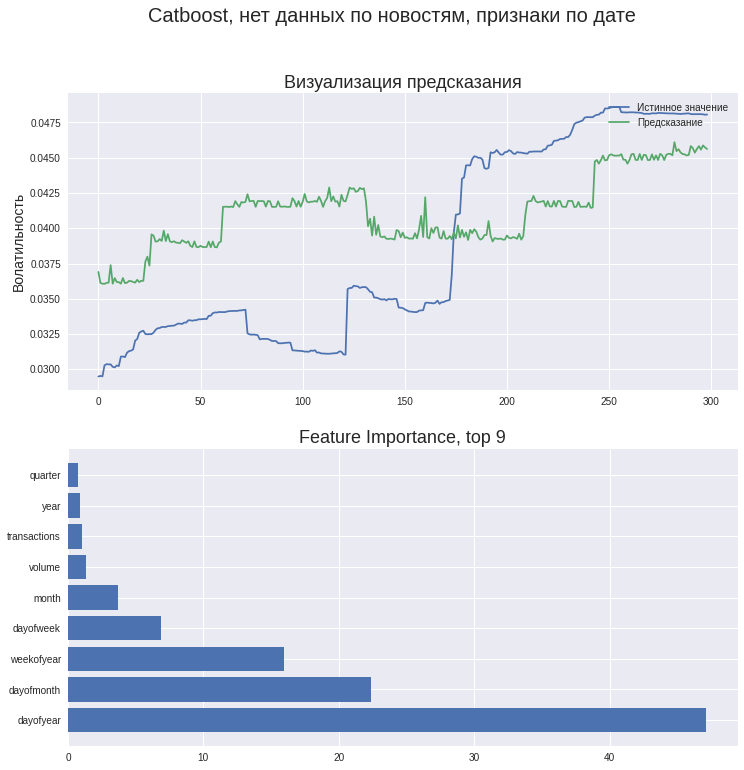

In [ ]:
model_nm = 'Catboost, нет данных по новостям, признаки по дате'
predict_and_postprocess(boosting_no_new_and_date, y_test, X_test, model_nm)

Видно, что данные по дате вносят сильный вклад в структуру дерева, и, как следствие, влияют на предсказание.

#### v2w эмбеддинги, с фичами по дате

In [ ]:
boosting_v2w_and_date = CatBoostRegressor(
    random_state=42, 
    n_estimators=1200,
    loss_function = 'MAPE',
    verbose = False
)

boosting_v2w_and_date.fit(X_train_v2w, y_train)

Значение метрик на тесте :
 MSE=7.175e-05
 MAE=0.006991
 MAPE=0.2048


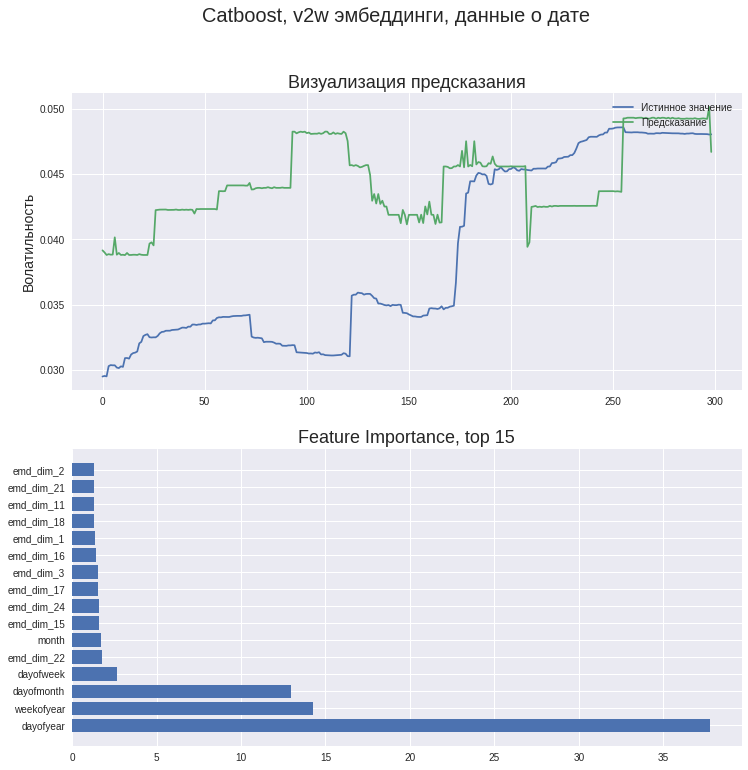

In [ ]:
model_nm = 'Catboost, v2w эмбеддинги, данные о дате'
predict_and_postprocess(boosting_v2w_and_date, y_test, X_test_v2w, model_nm)

Признаки по дате показали себя намного лучше эмбеддингов

#### `transformers` эмбеддинги, данные о дате

In [ ]:
boosting_tr_and_date = CatBoostRegressor(
    random_state=42, 
    n_estimators=1200,
    loss_function = 'MAPE',
    verbose = False
)

boosting_tr_and_date.fit(X_train_tr, y_train_tr)

Значение метрик на тесте :
 MSE=0.0001522
 MAE=0.01031
 MAPE=0.3032


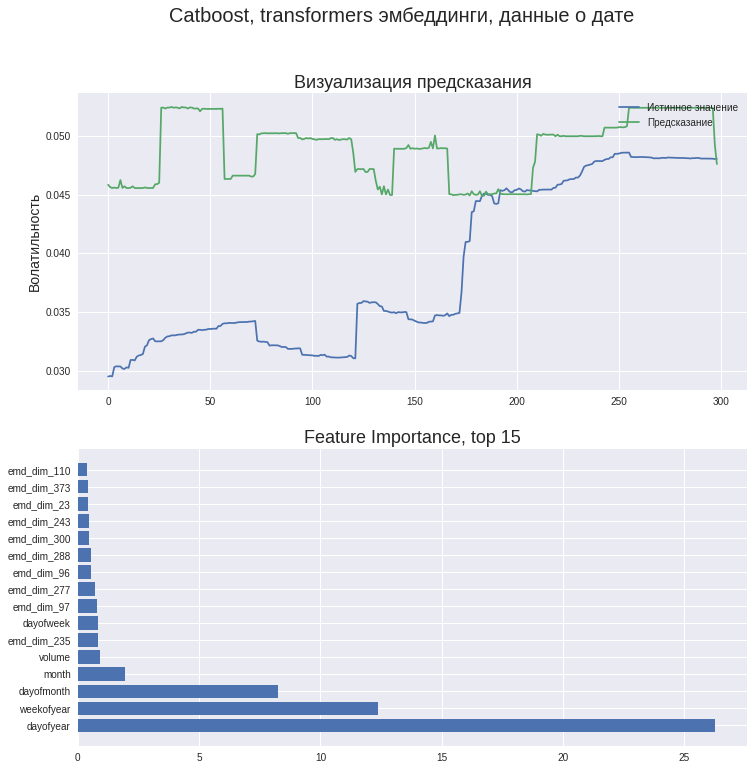

In [ ]:
model_nm = 'Catboost, transformers эмбеддинги, данные о дате'
predict_and_postprocess(boosting_tr_and_date, y_test, X_test_tr, model_nm)

И снова признаки по дате показали себя лучше всего.

#### `transformers` эмбеддинги, данные о дате + PCA на 120 компонент

In [ ]:
pca = PCA(n_components = 120)

scaler = StandardScaler()
scaler.fit(X_train_tr)

scaled_train = scaler.transform(X_train_tr)
scaled_test = scaler.transform(X_test_tr)

XPCAr_train = pca.fit_transform(scaled_train)
XPCAr_test = pca.fit_transform(scaled_test)

In [ ]:
boosting_pca_date = CatBoostRegressor(
    random_state=42, 
    n_estimators=1200,
    loss_function = 'MAPE',
    verbose = False
)

boosting_pca_date.fit(XPCAr_train, y_train_tr)
pred_pca_date = boosting_pca_date.predict(XPCAr_test)

Значение метрик на тесте :
 MSE=7.338e-05
 MAE=0.007773
 MAPE=0.2114


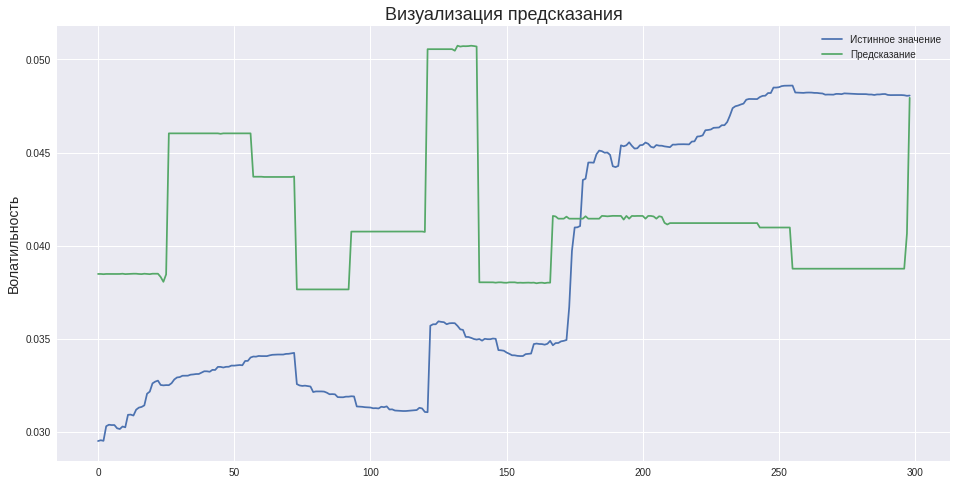

In [ ]:
model_nm = 'Catboost, transformers эмбеддинги, данные о дате, PCA 120 компонент'
predict_and_postprocess(boosting_pca_date, y_test, XPCAr_test, model_nm, False)

Кажется, признаки по дате не повлияли на этот пайплайн

Признаки по дате, конечно, хорошо помогли улучшить результат. Теперь добавим лаг предыдущих значений.

### Lag Предыдущих значений

In [ ]:
lag_lst = [WINDOW_SZ+1, 2*WINDOW_SZ+1, 3*WINDOW_SZ+1, 5*WINDOW_SZ+1, 10*WINDOW_SZ+1]

X_train_tr, y_train_tr = generate_lag_features_train(X_train_tr, pd.DataFrame(y_train_tr), lag_lst)[10*WINDOW_SZ+1:], y_train_tr[10*WINDOW_SZ+1:]
X_train, y_train = generate_lag_features_train(X_train, pd.DataFrame(y_train), lag_lst)[10*WINDOW_SZ+1:], y_train[10*WINDOW_SZ+1:]
X_train_v2w, y_train_v2w = generate_lag_features_train(X_train_v2w, pd.DataFrame(y_train_v2w), lag_lst)[10*WINDOW_SZ+1:], y_train_v2w[10*WINDOW_SZ+1:]

X_test_tr = generate_lag_features_test(X_test_tr, pd.DataFrame(y_train_tr), lag_lst)
X_test = generate_lag_features_test(X_test, pd.DataFrame(y_train), lag_lst)
X_test_v2w = generate_lag_features_test(X_test_v2w, pd.DataFrame(y_train_v2w), lag_lst)

#### Lag значений + признаки оп дате, нет новостей.

In [ ]:
boosting_no_new_and_lag = CatBoostRegressor(
    random_state=42, 
    n_estimators=1200,
    loss_function = 'MAPE',
    verbose = False
)

boosting_no_new_and_lag.fit(X_train, y_train)

Значение метрик на тесте :
 MSE=0.0005621
 MAE=0.02244
 MAPE=0.6222


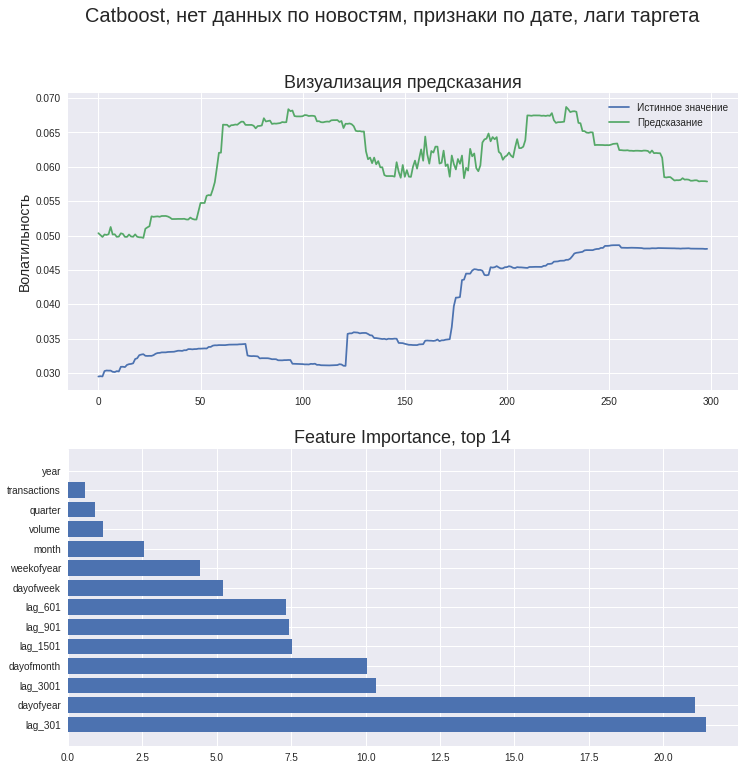

In [ ]:
model_nm = 'Catboost, нет данных по новостям, признаки по дате, лаги таргета'
predict_and_postprocess(boosting_no_new_and_lag, y_test, X_test, model_nm)

Видно, что лаги и признаки по дате дают очень большое влияние.

#### Lag значений, признаки по дате, v2w эмбеддинги

In [ ]:
boosting_v2w_and_lag = CatBoostRegressor(
    random_state=42, 
    n_estimators=1200,
    loss_function = 'MAPE',
    verbose = False
)

boosting_v2w_and_lag.fit(X_train_v2w, y_train)

Значение метрик на тесте :
 MSE=0.0003422
 MAE=0.01707
 MAPE=0.482


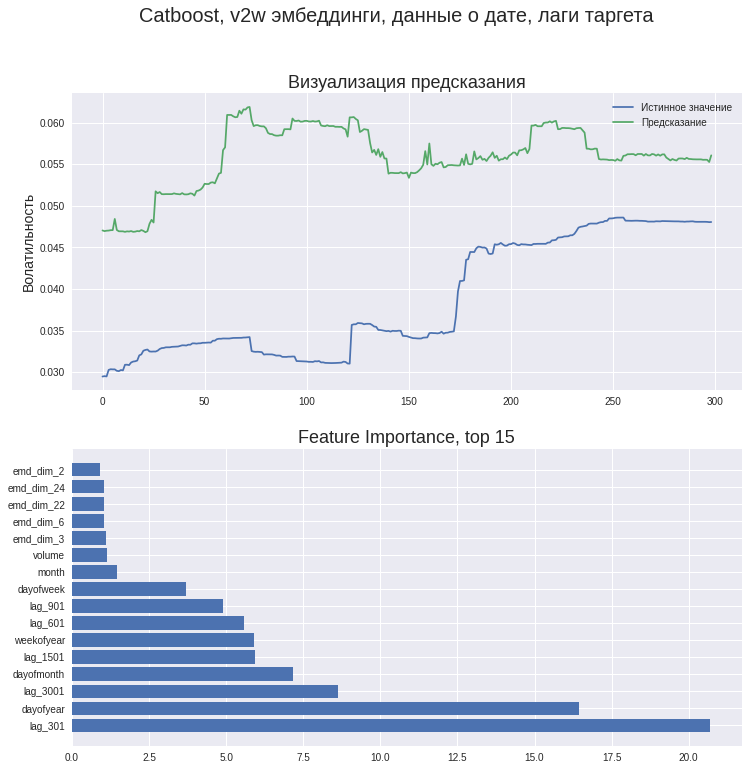

In [ ]:
model_nm = 'Catboost, v2w эмбеддинги, данные о дате, лаги таргета'
predict_and_postprocess(boosting_v2w_and_lag, y_test, X_test_v2w, model_nm)

`feature importance` аналогична предыдущей в целом.

#### Lag значений, признаки по дате, `transformers` эмбеддинги

In [ ]:
boosting_tr_and_lag = CatBoostRegressor(
    random_state=42, 
    n_estimators=1200,
    loss_function = 'MAPE',
    verbose = False
)

boosting_tr_and_lag.fit(X_train_tr, y_train_tr)

Значение метрик на тесте :
 MSE=0.0003784
 MAE=0.0182
 MAPE=0.5094


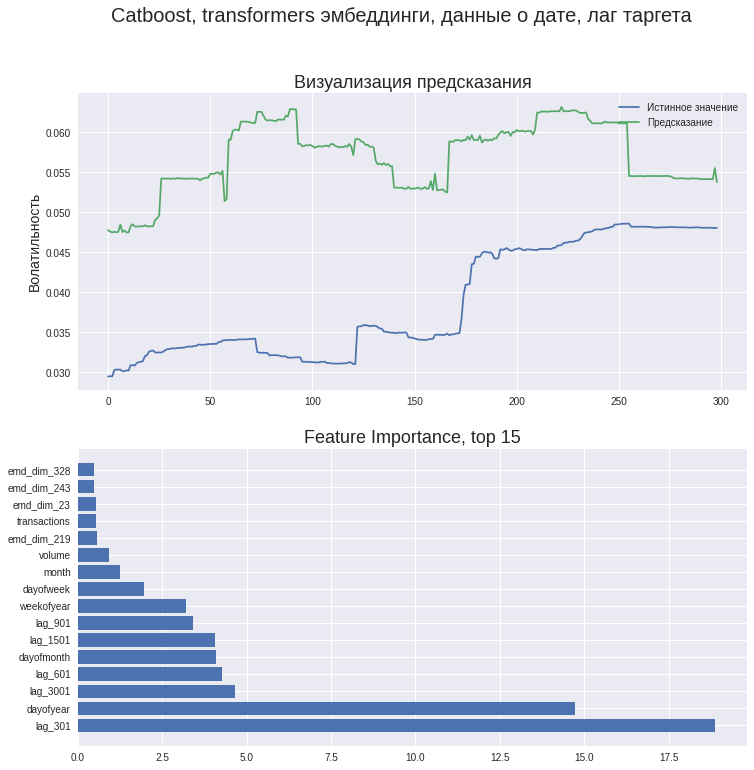

In [ ]:
model_nm = 'Catboost, transformers эмбеддинги, данные о дате, лаг таргета'
predict_and_postprocess(boosting_tr_and_lag, y_test, X_test_tr, model_nm)

Видно, что снова лаги показали наибольшее влияние на структуру дерева. Само качество предсказаний, кажется, лучше не стало, т.к. вносится нкоторое смещение вначале

#### Lag значений, признаки по дате, `transformers` эмбеддинги + PCA

In [ ]:
pca = PCA(n_components = 120)

scaler = StandardScaler()
scaler.fit(X_train_tr)

scaled_train = scaler.transform(X_train_tr)
scaled_test = scaler.transform(X_test_tr)

XPCAr_train = pca.fit_transform(scaled_train)
XPCAr_test = pca.fit_transform(scaled_test)

In [ ]:
boosting_pca_lag = CatBoostRegressor(
    random_state=42, 
    n_estimators=1200,
    loss_function = 'MAPE',
    verbose = False
)

boosting_pca_lag.fit(XPCAr_train, y_train_tr)

Значение метрик на тесте :
 MSE=5.439e-05
 MAE=0.006868
 MAPE=0.1792


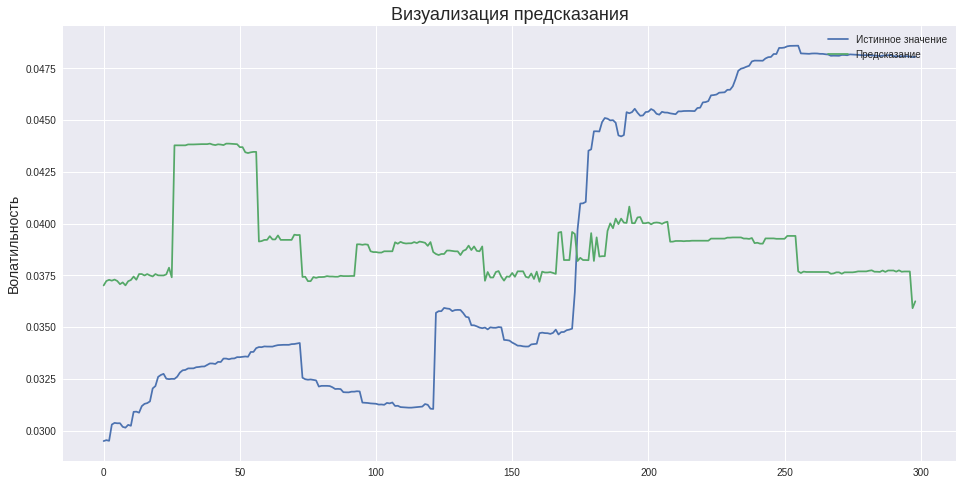

In [ ]:
model_nm = 'Catboost, transformers эмбеддинги, данные о дате, лаг таргета, PCA 120 компонент'
predict_and_postprocess(boosting_pca_lag, y_test, XPCAr_test, model_nm, False)

Видно, что PCA сильно уменьшает разброс предсказаний и оно становится похожим на константу. Конечно, это влияет на метрики положительно, однако все равно очень хорошего результата не получается. 

### Time-Series Validation

Кажется, стоит попробовать добавить валидацию, т.к. это поможет учесть поведение волатильности на последних днях.

In [ ]:
steps = [
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components = 120)), 
    ('CatBoost', CatBoostRegressor(verbose=False, loss_function = 'MAPE'))
]

pipeline = Pipeline(steps)

# Сетка параметров
random_grid = {
                "CatBoost__depth": [2, 4, 6, 8],
                "CatBoost__learning_rate": [0.03,0.05,0.1, 0.2],
                "CatBoost__n_estimators": [100, 200, 400, 600, 800, 1000, 1200, 1500, 2000],
              }

val_wind = TEST_SZ
train_len =  len(X_train_tr)
    
cv = [
            [np.arange(0 , train_len- 3*TEST_SZ), np.arange(train_len - 2*TEST_SZ , train_len - TEST_SZ)],
            [np.arange(0 , train_len - 4*TEST_SZ), np.arange(train_len - 3*TEST_SZ , train_len - 2*TEST_SZ)],
    ]

validation = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=random_grid,
                n_iter=10,
                cv=cv,
                scoring="neg_mean_absolute_percentage_error",
                random_state=42,
                n_jobs=-1,
                verbose=10,
            )



validation.fit(X_train_tr, y_train)
validated_model = validation.best_estimator_

Fitting 2 folds for each of 10 candidates, totalling 20 fits


Значение метрик на тесте :
 MSE=6.743e-05
 MAE=0.006199
 MAPE=0.1842


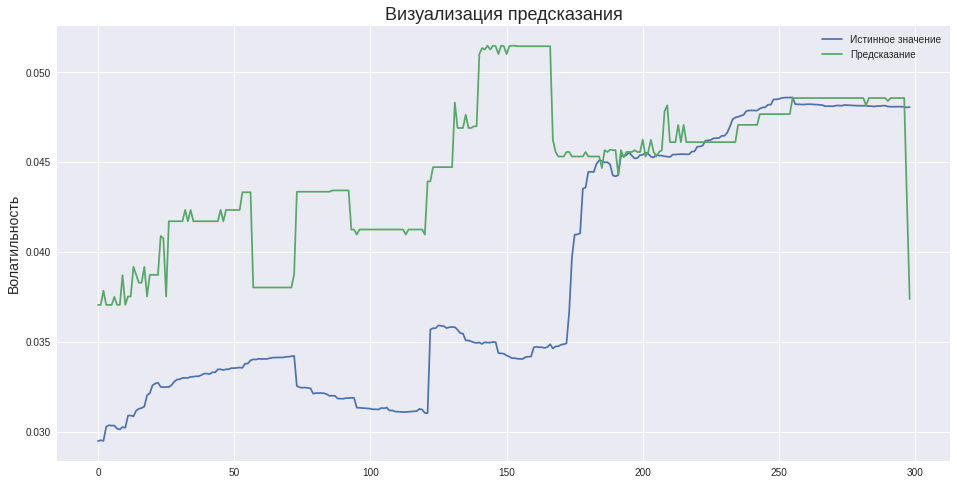

In [ ]:
model_nm = 'Catboost, transformers эмбеддинги, данные о дате, лаг таргета, PCA 120 компонент + валидация'
predict_and_postprocess(validated_model, y_test, X_test_tr, model_nm, False)

Видно, что валидация очень хорошо помогла улучшить качество предсказания. В целом получилось неплохо.

## Подведение итогов, выводы

Для финальной визуализации отрисуем все предсказания и тест на одном интерактивном графике, а также добавим группировку по кнопке по порядку добавления новых фичей.

In [ ]:
x = np.arange(len(metr_df) + 1)
ys = [i+x+(i*x)**2 for i in range(len(metr_df) + 1)]

colors = cm.rainbow(np.linspace(0, 1, len(ys)))
colors = [rgb2hex(i) for i in colors]

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=test_dates, y=y_test, mode='lines', line=dict(color=colors[0]), name='Тест'))

labels = model_nm_lst

for i, (label, pred, color) in enumerate(zip(labels, preds_lst, colors[1:])):
  
  if i < 4:
    group_title = '1'
    legendgrouptitle_text="Нет информации о дате"
  elif i < 8:
    group_title = '2'
    legendgrouptitle_text="Информация только о дате"
  else:
    group_title = '3'
    legendgrouptitle_text="Информация о дате и лаги"

  fig.add_trace(go.Scatter(x=test_dates, y=pred,
                                 line=dict(color=color),
                                 mode='lines', name=label, legendgroup=group_title, legendgrouptitle_text=legendgrouptitle_text))
        
fig.update_layout(title='Интерактивная визуализация всех предсказаний')
fig.show()

Посмотрим на итоговые метрики.

In [ ]:
metr_df

,Model,MSE,MAE,MAPE
0,"Catboost, без новостей",0.000092,0.007888,0.208985
1,"Catboost, v2w эмбеддинги",0.000129,0.008696,0.247538
2,"Catboost, transformers эмбеддинги",0.000133,0.008682,0.254063
3,"Catboost, transformers эмбеддинги + PCA 120 комп.",0.000075,0.007533,0.210737
4,"Catboost, нет данных по новостям, признаки по ...",0.000039,0.005712,0.159399
5,"Catboost, v2w эмбеддинги, данные о дате",0.000072,0.006991,0.204783
6,"Catboost, transformers эмбеддинги, данные о дате",0.000152,0.010307,0.303208
7,"Catboost, transformers эмбеддинги, данные о да...",0.000073,0.007773,0.211436
8,"Catboost, нет данных по новостям, признаки по ...",0.000562,0.022438,0.622210
9,"Catboost, v2w эмбеддинги, данные о дате, лаги ...",0.000342,0.017074,0.481951


---

## Выводы

* Судя по предсказаниям, модель из новостей в принципе неплохо предсказывает динамику волатильности, однако предсказания сами по себе сильно смещены.

* Для применения модели к торговой стратегии достаточно важно понимать, как на фиксированном краткосрочном периоде поведет себя волатильность, т.е. хорошо аппроксимировать максимум и минмум волатильности  на отрезке. С таким смещением модели справятся плохо

* Вероятно, стоит оценивать качество по другой метрике, т.к. стандартные метрики не учитывают особенности второго пункта

* Также стоит попробовать нейросетевой подход, чтобы иметь возможность делать несколько новых итераций `back propogation` на новых данных.

* Из полученных результатов сложно понять, повлияли ли новости на кач-во предсказания. Стоит сделать статистический тест. 